Classification of Cards

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [13]:
import pathlib

dataset_url = "C:\\Rohit\\Projects\\Card Classifier\\dataset\\archive (1)\\train"
data_dir = pathlib.Path(dataset_url).with_suffix('')
print(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

test_dir= "C:\\Rohit\\Projects\\Card Classifier\\dataset\\archive (1)\\test"
test_dir = pathlib.Path(test_dir).with_suffix('')
test_count = len(list(test_dir.glob('*/*.jpg')))
print(test_count)

C:\Rohit\Projects\Card Classifier\dataset\archive (1)\train
7624
265


In [14]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  #validation_split=0.0,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  #validation_split=1.0,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of dia

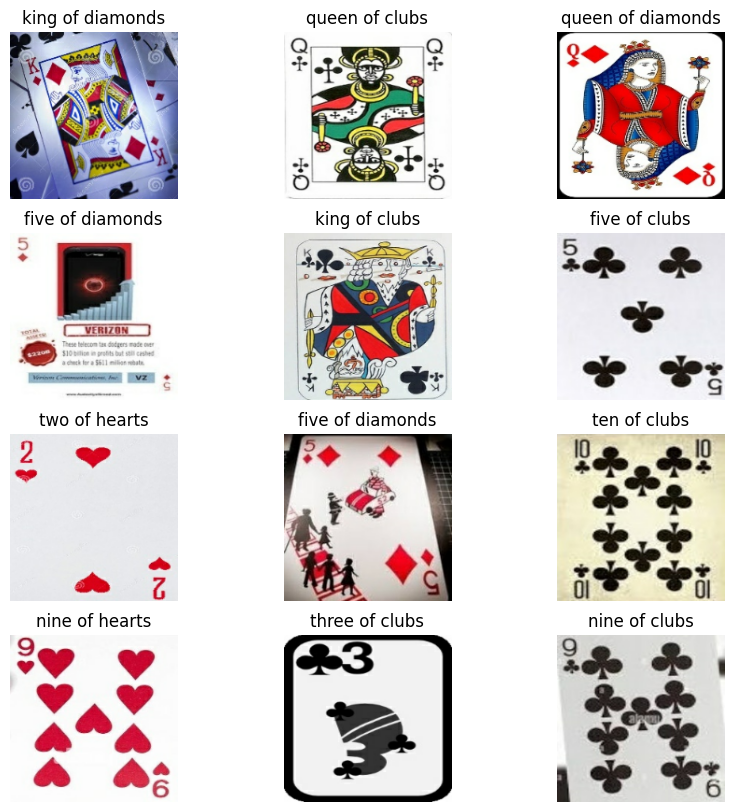

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Rohit\Python\python-3.11.4-embed-amd64\Python\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,995,477 (15.24 MB)

 Trainable params: 3,995,477 (15.24 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 62s 245ms/step - accuracy: 0.1599 - loss: 3.3500 - val_accuracy: 0.5623 - val_loss: 1.6034
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 56s 236ms/step - accuracy: 0.5684 - loss: 1.5713 - val_accuracy: 0.7170 - val_loss: 1.1333
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 62s 261ms/step - accuracy: 0.7840 - loss: 0.8125 - val_accuracy: 0.7585 - val_loss: 1.0181
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 59s 246ms/step - accuracy: 0.9192 - loss: 0.3217 - val_accuracy: 0.7358 - val_loss: 1.3003
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 64s 267ms/step - accuracy: 0.9606 - loss: 0.1709 - val_accuracy: 0.7811 - val_loss: 1.1867
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 59s 249ms/step - accuracy: 0.9763 - loss: 0.1308 - val_accuracy: 0.8000 - val_loss: 1.1668
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 67s 281ms/step - accuracy: 0.9894 - loss: 0.0602 - val_accuracy: 0.7736 - val_loss: 1.3729
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 64s 266ms/step - accuracy: 0.9893 - loss: 0

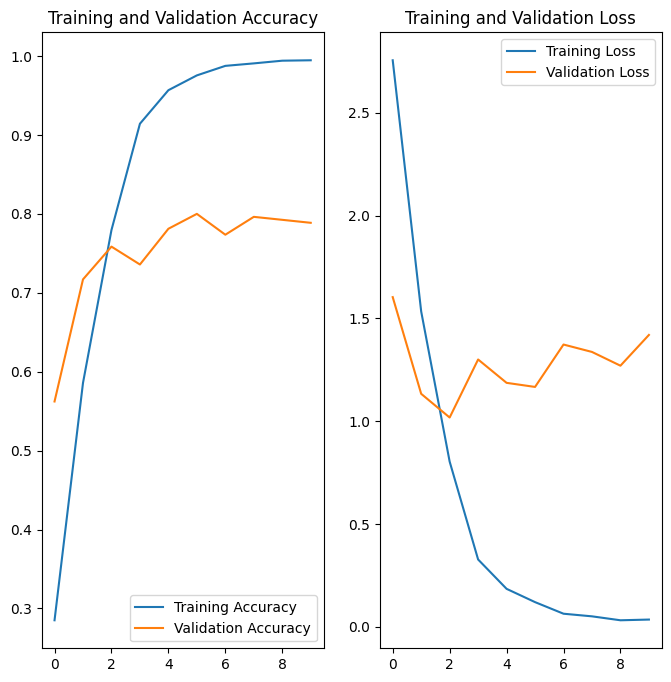

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('../models/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp7qyc4a0_\assets


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp7qyc4a0_\assets


Saved artifact at 'C:\Users\PC\AppData\Local\Temp\tmp7qyc4a0_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 53), dtype=tf.float32, name=None)
Captures:
  1919795316304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1919795317072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1919795316880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1919795316496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1919795315152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1919795317648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1919795316112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1919795318608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1919795314768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1919795319568: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [33]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

sample_img_path='../samples/9.jpg'

img = tf.keras.utils.load_img(
    sample_img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
This image most likely belongs to five of hearts with a 91.10 percent confidence.


In [24]:
TF_MODEL_FILE_PATH = '../models/model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor'], 'outputs': ['output_0']}}

In [25]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite
predictions_lite = classify_lite(keras_tensor=img_array)['output_0']
score_lite = tf.nn.softmax(predictions_lite)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)
print(np.max(np.abs(predictions - predictions_lite)))

This image most likely belongs to ten of spades with a 40.61 percent confidence.
3.33786e-06
